<img src="escuela-de-economia.png" width="260" height="60">
<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
<b>Laboratorio:</b>
<div style="font-size:175%;color:white; background-color: #0064b0;">Tema 5: Modelos para series con tendencia</div>
<div style="font-size:250%;color:white; background-color: #0064b0;">Replicando el trabajo de Granger y Newbold 1974</div> 
</center>
<i>Creado:     2020-May-01 
    <br>
    Actualizado: 2020-Oct-25</i>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

import seaborn as sns

from scipy.stats import t as t_Student

plt.style.use('seaborn')
plt.rc('figure', figsize=(15,4))
plt.rc('axes', titlesize=20, labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

## Regresión de una caminata aleatoria contra otra caminata aleatoria independiente

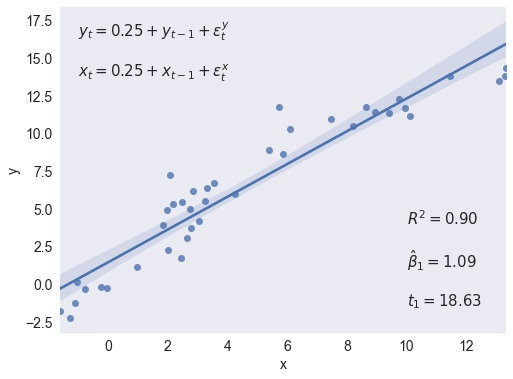

In [2]:
np.random.seed(240)
e = np.random.randn(2,40)
y, x = (0.25+e).cumsum(axis=1)
X = sm.add_constant(x)
res = sm.OLS(y, X).fit()


fig, ax = plt.subplots(figsize=[8,6])
sns.regplot(x,y,'*',ax=ax)
ax.set(xlabel='x', ylabel='y')

statslabel = f'$R^2={res.rsquared:.2f}$'
statslabel += f'\n\n$\\hat\\beta_1={res.params[1]:.2f}$'
statslabel += f'\n\n$t_1={res.tvalues[1]:.2f}$'
ax.annotate(statslabel, (10,5), size=15, va='top')


modellabel = r'$y_t = 0.25 + y_{t-1} + \epsilon^y_t$'
modellabel += '\n\n$x_t = 0.25 + x_{t-1} + \\epsilon^x_t$'
ax.annotate(modellabel, (-1,17.5), size=15, va='top')

ax.grid(False)
fig.savefig('regresion-espuria-1caso.pdf', bbox_inches='tight')

In [3]:
res.params

array([1.44456189, 1.08570021])

In [4]:
np.linalg.solve(X.T @ X, X.T @ y)

array([1.44456189, 1.08570021])

## Experimento de Monte Carlo para determinar la distribución del estadítico t

In [5]:
def regresion_estacionaria(T=100):
    y, x = np.random.randn(2,T)
    X = sm.add_constant(x)
    res = sm.OLS(y, X).fit()
    return res.tvalues[1]

In [6]:
def regresion_espuria(T=100):
    e = np.random.randn(2,T)
    y, x = e.cumsum(axis=1)
    X = sm.add_constant(x)
    res = sm.OLS(y, X).fit()
    return res.tvalues[1]

In [7]:
%%time
N = 100_000
np.random.seed(12345)
tvalues = pd.Series([regresion_estacionaria() for _ in range(N)])

np.random.seed(12345)
zvalues = pd.Series([regresion_espuria() for _ in range(N)])

Wall time: 1min 58s


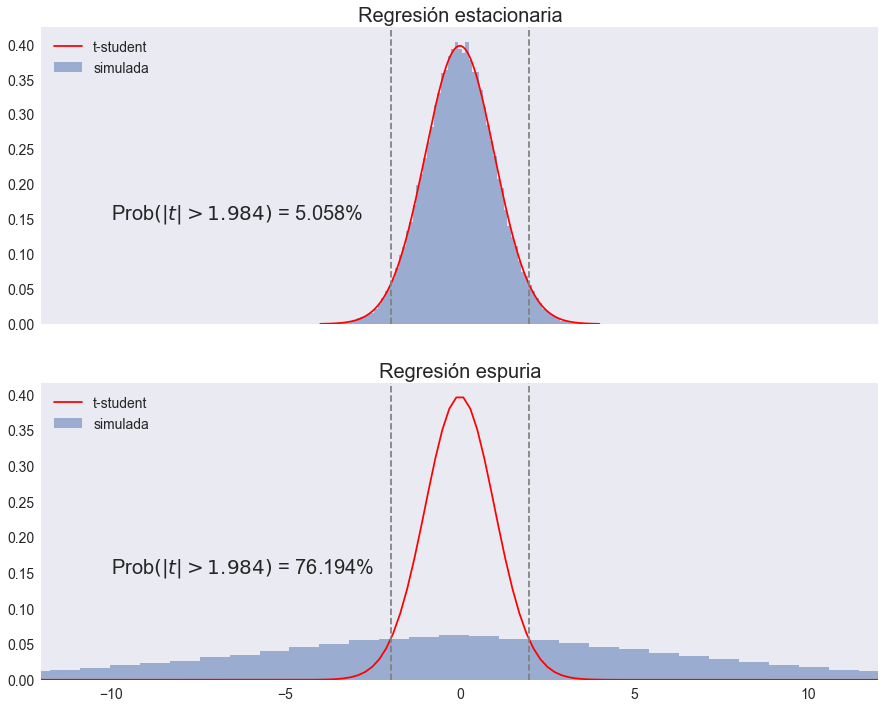

In [8]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=[15, 12], sharex=True)

maxtval = 12
t5crit = t_Student.isf(0.05/2, 98)


# regresión estacionaria
ff, edges = np.histogram(tvalues, bins=100, density=True)
center = (edges[1:] + edges[:-1])/2
w = center[1] - center[0]

ax0.bar(center, ff, width=w, alpha=0.5)
xvals = np.linspace(-4,4, 200)
ax0.plot(xvals, t_Student.pdf(xvals, df=98), '-r')
ax0.set(xlim=[-maxtval, maxtval], title='Regresión estacionaria')
ax0.legend(['t-student', 'simulada'], loc='upper left')


# regresión espuria
ff, edges = np.histogram(zvalues, bins=100, density=True)
center = (edges[1:] + edges[:-1])/2
w = center[1] - center[0]

ax1.bar(center, ff, width=w, alpha=0.5)
xvals = np.linspace(-20, 20, 200)
ax1.plot(xvals, t_Student.pdf(xvals, df=98), '-r')
ax1.set(xlim=[-maxtval,maxtval], title='Regresión espuria')
ax1.legend(['t-student', 'simulada'], loc='upper left')

# valores críticos
opciones = dict(ls="--", color='gray')
ax0.axvline(t5crit, **opciones)
ax0.axvline(-t5crit, **opciones)
ax1.axvline(t5crit, **opciones)
ax1.axvline(-t5crit, **opciones)

# error tipo I
err1 = (tvalues.abs() > t5crit).mean()*100
ax0.annotate(f'Prob$\\left(|t| > 1.984\\right)$ = {err1:.3f}%', (-10,0.15), size=20)

err1bad = (zvalues.abs() > t5crit).mean()*100
ax1.annotate(f'Prob$\\left(|t| > 1.984\\right)$ = {err1bad:.3f}%', (-10,0.15), size=20)

ax0.grid(False)
ax1.grid(False)
fig.savefig('regresion-espuria.pdf', bbox_inches='tight')

**NOTA** Una versión anterior de este archivo incluía una simulación de la prueba de Dickey y Fuller. Ese código ahora aparece en el cuaderno DickeyFuller.ipynb.